test a variable epsilon search function

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500.zip'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

Below we also see that increasing the number of resarts without changing restarts:iterations improves the performance. It allows for a lower dynamic epsilon and higher ASRs

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG


import pandas as pd
import numpy as np

import KBMproject.utilities as utils
from tqdm import tqdm
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
try:
    agent = PPO.load(path=f"20 bin PPO 500 results/{AGENT_NAME}")
    print('Model loaded from storage')
except:
    print(f'Model: {AGENT_NAME} not found')

Model loaded from storage


In [5]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

In [6]:
observation_masks = pd.read_csv('observation_masks.csv')

SHould this be a class so it can remember the prev eps?

In [7]:
def dynamic_distortion(sample, victim_policy, ART_atk, mask:list, ART_atk_kwargs:dict=None, eps_candidates:list=[0.05], init_idx:int=None):
    """finds the minimum successful distortion epsilon from a given SORTED list, 
    by iteratively remove list items until one remains with binary search
    returns adversarial example, adversarial action, eps used to produce them, and the difference between the original and adversarial actions"""

    eps_candidates.sort() #ensures iput is sorted for binary search
    if init_idx is not None: #we migh have some insight on where to start based on our situation, like how far a target is from the baseline
        idx = init_idx
    else:
        idx = (len(eps_candidates))//2 #middle 
    
    kwargs = ART_atk_kwargs #do I need to purge eps if it's in here?
    min_eps_sample = sample
    if sample.ndim == 1: #ART requires 2d input
        sample = np.expand_dims(sample, axis=0)
    a = a_min_eps = np.argmax(victim_policy.predict(sample, training_mode=False)) #nn outputs -> largest index corresponds to the chosen action, agent.predict()
    eps_min = np.nan #remains nan if no adversarial sample is generated

    while len(eps_candidates) >= 1: #list is not empty, we remove all tested values
        eps = eps_candidates[idx]
        #define attack
        try: #for ACG/APGT which have eps_step, which changes depending on eps so isn't a static kwarg
            attack = ART_atk(estimator=victim_policy, eps=eps, eps_step=eps/3, verbose=False, **kwargs)
        except: #for something like PGT which doesn't have eps_setp
            attack = ART_atk(estimator=victim_policy, eps=eps, verbose=False, **kwargs)

        adv_sample = attack.generate(sample, mask=mask)
        a_adv = np.argmax(victim_policy.predict(adv_sample, training_mode=False))
        
        if a!=a_adv: #adversarial example successful
            eps_candidates = eps_candidates[:idx] #this worked, so only keep lower values, slice is exclusive because we save the values below
            min_eps_sample = adv_sample
            a_min_eps = a_adv
            eps_min = eps
        else: #no adversarial sample found
            eps_candidates = eps_candidates[idx+1:] #This didn't work, so only keep higher values, slice is exclusive
        
        idx = (len(eps_candidates))//2 #how can this produce a value out of range? what happens with len 1?
    a_dist = abs(a - a_min_eps)
    return np.squeeze(min_eps_sample), np.array([a_min_eps]), eps_min, a_dist #agent.predict returns an array

In [8]:
def eval_untargeted_dynamic_distortion_attack(agent, env, ART_atk, ART_atk_kwargs:dict=None, eps_candidates:list=[0.05], time_steps:int=None, mask:list=None):
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack,
    using the smallest distortion from a list"""

    from math import isnan

    obs_list = []
    asr = 0
    eps_list = []
    avg_action_dist = 0

    observations = env.reset()
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is None:
        mask=np.ones(agent.observation_space.shape[0]) #1 for all features

    victim_policy = classifier(
                            model=utils.extract_actor(agent),
                            loss=CrossEntropyLoss(), 
                            nb_classes=env.action_space[0].n,
                            input_shape=agent.observation_space.shape,
                            device_type='gpu'
                            )

    for i in tqdm(range(time_steps)):

        obs_list.append(observations)

        _, a_adv, eps, a_dist = dynamic_distortion(sample=observations, 
                                            victim_policy=victim_policy,
                                            ART_atk=ART_atk, 
                                            ART_atk_kwargs=ART_atk_kwargs,
                                            mask=mask,
                                            eps_candidates=eps_candidates)
        
        eps_list.append(eps)
        if not isnan(eps): #nan returned if no eps worked
            asr+=1

        observations, _, _, _ = env.step(a_adv)

        avg_action_dist = (avg_action_dist*(i) + a_dist)/(i+1)

        if env.done:
            break
    
    obs_list.append(observations)
    asr/=time_steps
    print(f'The Adversarial success rate is: {asr}')
    print(f'The average distance between optinmal and adversarial actions is: {avg_action_dist}')
    return utils.format_kpis(env), np.array(obs_list), np.array(eps_list)

In [59]:
def better_dynamic_distortion(victim_policy, atk_candidates:list, generate_kwargs:dict=None):
    """finds the minimum successful distortion epsilon from a given SORTED list, 
    by iteratively remove list items until one remains with binary search
    expects a lits of tupples, containing an attack obsect with gereate() attribute, and an epsilon value.
    returns adversarial example, adversarial action, eps used to produce them, and the difference between the original and adversarial actions"""

    idx = (len(atk_candidates))//2 #middle
    best_candidate_idx = list(range((len(atk_candidates)))) #assigned an index for each candidate
    kwargs = generate_kwargs
    atk_idx = 0
    eps_idx = 1
    min_eps = None
    
    kwargs = generate_kwargs
    if kwargs['x'].ndim == 1: #ART requires 2d input
        kwargs['x'] = np.expand_dims(kwargs['x'], axis=0)
    min_eps_sample = kwargs['x']
    a = a_min_eps = np.argmax(victim_policy.predict(kwargs['x'], training_mode=False)) #nn outputs -> largest index corresponds to the chosen action, agent.predict()
    #kwargs['y'] = np.array([a]) #does passing in the action make this faster? probably not

    while len(atk_candidates) >= 1: #list is not empty, we remove all tested values
        adv_sample = atk_candidates[idx][atk_idx].generate(**kwargs)
        a_adv = np.argmax(victim_policy.predict(adv_sample, training_mode=False))
        
        if a!=a_adv: #adversarial example successful
            min_eps = atk_candidates[idx][eps_idx]
            atk_candidates = atk_candidates[:idx] #this worked, so only keep lower values, slice is exclusive because we save the values below
            min_eps_sample = adv_sample
            a_min_eps = a_adv
        else: #no adversarial sample found
            atk_candidates = atk_candidates[idx+1:] #This didn't work, so only keep higher values, slice is exclusive
            best_candidate_idx = best_candidate_idx[idx+1:]

        idx = (len(atk_candidates))//2
    a_dist = abs(a - a_min_eps)
    return np.squeeze(min_eps_sample), np.array([a_min_eps]), min_eps, a_dist #agent.predict returns an array

In [49]:
def better_eval_untargeted_dynamic_distortion_attack(agent, env, ART_atk, ART_atk_kwargs:dict=None, 
                                    eps_candidates:list=[0.05], init_step_coeff:float=None, time_steps:int=None, mask:list=None):
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack,
    using the smallest distortion from a list"""

    from math import isnan

    obs_list = []
    adv_obs_list = []
    asr = 0
    eps_list = []
    avg_action_dist = 0
    atk_list = [] #list of attacks for each eps candidate
    eps_candidates.sort() #sort list in ascending order

    observations = env.reset()
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is not None:
        generate_kwargs = dict(mask=mask)
    else:
        generate_kwargs = dict()

    victim_policy = classifier(
                            model=utils.extract_actor(agent),
                            loss=CrossEntropyLoss(), 
                            nb_classes=env.action_space[0].n,
                            input_shape=agent.observation_space.shape,
                            device_type='gpu'
                            )
    kwargs = ART_atk_kwargs
    kwargs['verbose'] = False #can crash jupyter
    #define list of attacks for each candidate epsilon
    if init_step_coeff is None:
        for eps in eps_candidates:
            kwargs['eps'] = eps
            atk = ART_atk(victim_policy, **kwargs)
            atk_list.append((atk, eps))
    else:
        for eps in eps_candidates:
            kwargs['eps'] = eps
            kwargs['eps_step'] = init_step_coeff*eps
            atk = ART_atk(victim_policy, **kwargs)
            atk_list.append((atk, eps))

    for i in tqdm(range(time_steps)):
        #eps = None #defaults to none if no adversarial examples are generated
        obs_list.append(observations) #next state
        #sample = np.expand_dims(observations, axis=0) #ART requires 2d input
        #a = a_adv = np.array([np.argmax(victim_policy.predict(sample, training_mode=False))]) #clean/default action
        generate_kwargs['x'] = observations  #sample

        adv_obs, a_adv, min_eps, a_dist = better_dynamic_distortion(victim_policy=victim_policy,
                                                            generate_kwargs=generate_kwargs,
                                                            atk_candidates=atk_list)
        adv_obs_list.append(adv_obs)
        if a_dist!=0:
            asr+=1
            eps_list.append(min_eps)
        else:
            eps_list.append(np.nan)

        observations, _, _, _ = env.step(a_adv)

        avg_action_dist = (avg_action_dist*(i) + a_dist)/(i+1)

        if env.done:
            break
    
    obs_list.append(observations)
    asr/=time_steps
    print(f'The Adversarial success rate is: {asr}')
    print(f'The average distance between optinmal and adversarial actions is: {avg_action_dist}')
    return utils.format_kpis(env), np.array(obs_list), np.array(adv_obs_list), np.array(eps_list)

In [36]:
%%time
init = 20
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, adv_obs, bestilons = better_eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.01,0.03,0.05,0.07],
                                          time_steps=None,
                                          mask=observation_masks['mask_time'].to_numpy(),
                                          init_step_coeff=2,
                                          )
pd.Series(bestilons).value_counts().plot.pie()
display(kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [4:09:28<00:01,  1.71s/it]  


The Adversarial success rate is: 0.9942915857974655
The average distance between optinmal and adversarial actions is: 2.6740495490352783
count    8709.000000
mean        0.024013
std         0.014822
min         0.010000
25%         0.010000
50%         0.030000
75%         0.030000
max         0.070000
dtype: float64


cost_function
annual_peak_average                      1.340796
carbon_emissions_total                   0.906544
cost_total                               0.821517
daily_one_minus_load_factor_average      0.365820
daily_peak_average                       0.973676
electricity_consumption_total            0.914501
monthly_one_minus_load_factor_average    1.002102
ramping_average                          1.291433
zero_net_energy                          1.108872
Name: District, dtype: float64

CPU times: total: 4h 6min 34s
Wall time: 4h 9min 29s


<Axes: ylabel='None'>

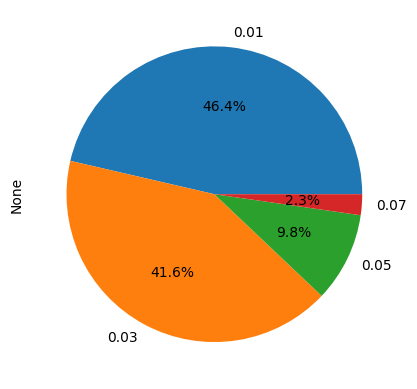

In [43]:
pd.Series(bestilons).value_counts().plot.pie(autopct='%1.1f%%')

100%|█████████▉| 8758/8759 [3:50:26<00:01,  1.58s/it]  


The Adversarial success rate is: 0.9932640712410092
The average distance between optinmal and adversarial actions is: 2.6687978079689523


cost_function
annual_peak_average                      1.204448
carbon_emissions_total                   0.906302
cost_total                               0.821248
daily_one_minus_load_factor_average      1.009029
daily_peak_average                       0.979524
electricity_consumption_total            0.914752
monthly_one_minus_load_factor_average    0.998397
ramping_average                          1.298869
zero_net_energy                          1.108929
Name: District, dtype: float64

CPU times: total: 3h 47min 59s
Wall time: 3h 50min 27s


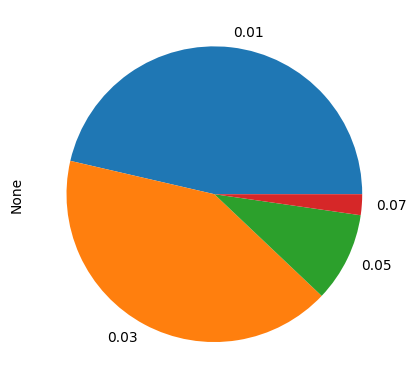

In [41]:
%%time
init = 40
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, adv_obs, bestilons = better_eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.01,0.03,0.05,0.07],
                                          time_steps=None,
                                          mask=observation_masks['mask_time'].to_numpy(),
                                          init_step_coeff=2,
                                          )
pd.Series(bestilons).value_counts().plot.pie()
display(kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [3:52:20<00:01,  1.59s/it]  


The Adversarial success rate is: 0.9928073981048064
The average distance between optinmal and adversarial actions is: 2.6836396848955344


cost_function
annual_peak_average                      1.204462
carbon_emissions_total                   0.906323
cost_total                               0.824031
daily_one_minus_load_factor_average      0.379868
daily_peak_average                       0.978546
electricity_consumption_total            0.914110
monthly_one_minus_load_factor_average    0.998648
ramping_average                          1.294624
zero_net_energy                          1.108684
Name: District, dtype: float64

CPU times: total: 3h 49min 12s
Wall time: 3h 52min 21s


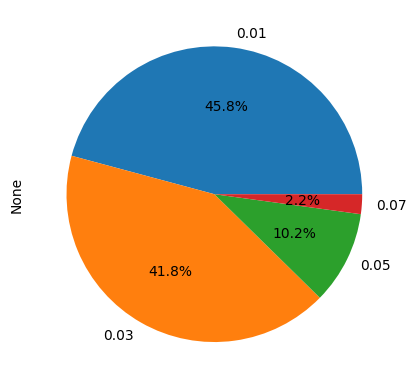

In [44]:
%%time
init = 30
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, adv_obs, bestilons = better_eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.01,0.03,0.05,0.07],
                                          time_steps=None,
                                          mask=observation_masks['mask_time'].to_numpy(),
                                          init_step_coeff=2,
                                          )
pd.Series(bestilons).value_counts().plot.pie(autopct='%1.1f%%')
display(kpis)

In [11]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe)
display(kpis)

100%|██████████| 100/100 [03:22<00:00,  2.02s/it]

The Adversarial success rate is: 0.97


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
print(pd.Series(bestilons).describe())
display(kpis)

count    97.000000
mean      0.033711
std       0.007948
min       0.030000
25%       0.030000
50%       0.030000
75%       0.030000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918482
carbon_emissions_total                   1.091155
cost_total                               0.967318
daily_one_minus_load_factor_average      1.008144
daily_peak_average                       1.164999
electricity_consumption_total            1.096677
monthly_one_minus_load_factor_average    0.971858
ramping_average                          1.337805
zero_net_energy                          1.094933
Name: District, dtype: float64

The fact that the required epsilon changes between runs suggestest that a larger computation buget would find adversarial sample. The varience can be explained by the the stochasticity of the search. Literally the random restarts. Maybe more would help? Maybe with fewer iterations? Time to investigate!

Let's try different cases where the max iterations are staill 500 (restarts*iterations)

In [14]:
init = 10
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

The Adversarial success rate is: 0.99
count    99.000000
mean      0.032828
std       0.008086
min       0.030000
25%       0.030000
50%       0.030000
75%       0.030000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918926
carbon_emissions_total                   1.117677
cost_total                               0.960236
daily_one_minus_load_factor_average      1.012116
daily_peak_average                       1.169350
electricity_consumption_total            1.104922
monthly_one_minus_load_factor_average    0.973528
ramping_average                          1.389525
zero_net_energy                          1.084991
Name: District, dtype: float64

In [15]:
init = 3
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [04:20<00:00,  2.61s/it]

The Adversarial success rate is: 0.98
count    98.000000
mean      0.033878
std       0.008925
min       0.030000
25%       0.030000
50%       0.030000
75%       0.030000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918507
carbon_emissions_total                   1.097707
cost_total                               0.959581
daily_one_minus_load_factor_average      1.008198
daily_peak_average                       1.165009
electricity_consumption_total            1.100311
monthly_one_minus_load_factor_average    0.971905
ramping_average                          1.380040
zero_net_energy                          1.094670
Name: District, dtype: float64

In [21]:
init = 2
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [05:59<00:00,  3.60s/it]

The Adversarial success rate is: 0.97
count    97.000000
mean      0.034845
std       0.009027
min       0.030000
25%       0.030000
50%       0.030000
75%       0.040000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918750
carbon_emissions_total                   1.108175
cost_total                               0.958831
daily_one_minus_load_factor_average      1.012976
daily_peak_average                       1.177690
electricity_consumption_total            1.122110
monthly_one_minus_load_factor_average    0.971922
ramping_average                          1.351256
zero_net_energy                          1.094854
Name: District, dtype: float64

In [16]:
init = 20
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

The Adversarial success rate is: 0.99
count    99.000000
mean      0.033030
std       0.008625
min       0.030000
25%       0.030000
50%       0.030000
75%       0.030000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918775
carbon_emissions_total                   1.180119
cost_total                               1.034073
daily_one_minus_load_factor_average      1.032251
daily_peak_average                       1.180140
electricity_consumption_total            1.186189
monthly_one_minus_load_factor_average    0.970540
ramping_average                          1.764281
zero_net_energy                          1.103548
Name: District, dtype: float64

In [17]:
init = 40
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

The Adversarial success rate is: 1.0
count    100.000000
mean       0.032700
std        0.008147
min        0.030000
25%        0.030000
50%        0.030000
75%        0.030000
max        0.070000
dtype: float64


cost_function
annual_peak_average                      0.919270
carbon_emissions_total                   1.092754
cost_total                               0.931931
daily_one_minus_load_factor_average      1.011644
daily_peak_average                       1.169478
electricity_consumption_total            1.084146
monthly_one_minus_load_factor_average    0.973208
ramping_average                          1.336699
zero_net_energy                          1.087400
Name: District, dtype: float64

In [18]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


The Adversarial success rate is: 0.99
count    99.000000
mean      0.032626
std       0.007770
min       0.030000
25%       0.030000
50%       0.030000
75%       0.030000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918529
carbon_emissions_total                   1.101925
cost_total                               0.937401
daily_one_minus_load_factor_average      1.011931
daily_peak_average                       1.169201
electricity_consumption_total            1.091983
monthly_one_minus_load_factor_average    0.973369
ramping_average                          1.358469
zero_net_energy                          1.085516
Name: District, dtype: float64

In [19]:
init = 100
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=100,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]

The Adversarial success rate is: 0.97
count    97.000000
mean      0.031753
std       0.005592
min       0.030000
25%       0.030000
50%       0.030000
75%       0.030000
max       0.070000
dtype: float64


cost_function
annual_peak_average                      0.918520
carbon_emissions_total                   1.082488
cost_total                               0.940333
daily_one_minus_load_factor_average      1.010470
daily_peak_average                       1.165014
electricity_consumption_total            1.073211
monthly_one_minus_load_factor_average    0.973278
ramping_average                          1.223642
zero_net_energy                          1.086073
Name: District, dtype: float64

##### Let's try different compute budgets/inits for more timesteps, the max variation was 3/100. We'll also test the lower bound by making the min 0.0125

In [34]:
init = 20
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.0125, 0.025,0.038,0.05,0.06,0.07],
                                          time_steps=1000,
                                          mask=observation_masks['mask_time'].to_numpy())
bestilons = pd.Series(bestilons)
print(bestilons.describe())
print('Epsilon freqencies:\n', bestilons.value_counts())
display(kpis)

100%|██████████| 1000/1000 [29:12<00:00,  1.75s/it]

The Adversarial success rate is: 0.99
The average distance between optinmal and adversarial actions is: 2.702000000000002
count    990.000000
mean       0.022611
std        0.013041
min        0.012500
25%        0.012500
50%        0.012500
75%        0.025000
max        0.070000
dtype: float64


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [35]:
bestilons = pd.Series(bestilons)
print(bestilons.describe())
print('Epsilon freqencies:\n', bestilons.value_counts())
display(kpis)

count    990.000000
mean       0.022611
std        0.013041
min        0.012500
25%        0.012500
50%        0.012500
75%        0.025000
max        0.070000
dtype: float64
Epsilon freqencies:
 0.0125    509
0.0250    272
0.0380    134
0.0500     47
0.0600     18
0.0700     10
dtype: int64


cost_function
annual_peak_average                      0.886363
carbon_emissions_total                   0.939280
cost_total                               0.831279
daily_one_minus_load_factor_average      0.934081
daily_peak_average                       0.922418
electricity_consumption_total            0.955215
monthly_one_minus_load_factor_average    0.919623
ramping_average                          1.201153
zero_net_energy                          1.067508
Name: District, dtype: float64

In [36]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.0125, 0.025,0.038,0.05,0.06,0.07],
                                          time_steps=1000,
                                          mask=observation_masks['mask_time'].to_numpy())
bestilons = pd.Series(bestilons)
print(bestilons.describe())
print('Epsilon freqencies:\n', bestilons.value_counts())
display(kpis)

100%|██████████| 1000/1000 [27:57<00:00,  1.68s/it]

The Adversarial success rate is: 0.994
The average distance between optinmal and adversarial actions is: 2.7079999999999997
count    994.000000
mean       0.022437
std        0.013054
min        0.012500
25%        0.012500
50%        0.012500
75%        0.025000
max        0.070000
dtype: float64
Epsilon freqencies:
 0.0125    519
0.0250    273
0.0380    125
0.0500     48
0.0600     19
0.0700     10
dtype: int64


cost_function
annual_peak_average                      0.940681
carbon_emissions_total                   0.944075
cost_total                               0.832127
daily_one_minus_load_factor_average      0.933295
daily_peak_average                       0.938743
electricity_consumption_total            0.956625
monthly_one_minus_load_factor_average    0.936396
ramping_average                          1.235662
zero_net_energy                          1.067573
Name: District, dtype: float64

In [38]:
init = 40
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.0125, 0.025,0.038,0.05,0.06,0.07],
                                          time_steps=1000,
                                          mask=observation_masks['mask_time'].to_numpy())
bestilons = pd.Series(bestilons)
print(bestilons.describe())
print('Epsilon freqencies:\n', bestilons.value_counts())
display(kpis)

100%|██████████| 1000/1000 [26:49<00:00,  1.61s/it]

The Adversarial success rate is: 0.993
The average distance between optinmal and adversarial actions is: 2.669999999999999
count    993.000000
mean       0.022403
std        0.013048
min        0.012500
25%        0.012500
50%        0.012500
75%        0.025000
max        0.070000
dtype: float64
Epsilon freqencies:
 0.0125    518
0.0250    273
0.0380    132
0.0500     41
0.0600     15
0.0700     14
dtype: int64


cost_function
annual_peak_average                      0.940683
carbon_emissions_total                   0.942267
cost_total                               0.833696
daily_one_minus_load_factor_average      0.934346
daily_peak_average                       0.932148
electricity_consumption_total            0.956545
monthly_one_minus_load_factor_average    0.931696
ramping_average                          1.246792
zero_net_energy                          1.061553
Name: District, dtype: float64

Over 1000 ts we see 50/10 performed best, so we'll try that for an episode

In [39]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.0125, 0.025,0.038,0.05,0.06,0.07],
                                          time_steps=None,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|█████████▉| 8758/8759 [4:15:35<00:01,  1.75s/it]  


The Adversarial success rate is: 0.9869848156182213
The average distance between optinmal and adversarial actions is: 3.3164744833885145
count    8645.000000
mean        0.023854
std         0.014210
min         0.012500
25%         0.012500
50%         0.025000
75%         0.025000
max         0.070000
dtype: float64


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.939415
cost_total                               0.871591
daily_one_minus_load_factor_average      1.165190
daily_peak_average                       1.000811
electricity_consumption_total            0.947866
monthly_one_minus_load_factor_average    0.992565
ramping_average                          1.342592
zero_net_energy                          1.098120
Name: District, dtype: float64

In [40]:
print('Epsilon freqencies:\n', pd.Series(bestilons).value_counts())

Epsilon freqencies:
 0.0125    4236
0.0250    2317
0.0380    1194
0.0500     529
0.0600     231
0.0700     138
dtype: int64


##### Let's try a full episode with our best candidate from the 100 ts experiment 40/12

In [20]:
init = 40
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.03,0.04,0.05,0.06,0.07],
                                          time_steps=None,
                                          mask=observation_masks['mask_time'].to_numpy())
print(pd.Series(bestilons).describe())
display(kpis)

100%|█████████▉| 8758/8759 [2:04:25<00:00,  1.17it/s]  


The Adversarial success rate is: 0.9868706473341705
count    8644.000000
mean        0.033147
std         0.007984
min         0.030000
25%         0.030000
50%         0.030000
75%         0.030000
max         0.070000
dtype: float64


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.939149
cost_total                               0.869627
daily_one_minus_load_factor_average      1.164950
daily_peak_average                       0.999718
electricity_consumption_total            0.947923
monthly_one_minus_load_factor_average    0.985544
ramping_average                          1.339283
zero_net_energy                          1.097721
Name: District, dtype: float64

##### with the default 5 restarts and 100 iterations, an eps of 0.05 has an ASR of 0.923 and 0.04 has an asr of 0.866 (note that epsilon is constant). This shows that the additional restarts with fewer iterations inproved the search, with ans ASR of nearly 99%. This suggests that additional diversification provided by the random restarts is more important than the intensification provided by additional iterations. 

perhaps the initial stepsize is too small?

In [ ]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.05, #default 0.3, this seems to be the smallest effective value
    eps_step=0.015, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = utils.define_attack(agent, env, ACG, **ACG_parameters)
kpis_5e2, adv_obs_5e2 = utils.eval_untargeted_attack_with_action_distance(agent, env, attack, 
                                                                                 time_steps=env.time_steps-1, 
                                                                                 mask=observation_masks['mask_time'].to_numpy())
display(kpis_5e2)

100%|█████████▉| 8758/8759 [1:25:59<00:00,  1.70it/s]  


The Adversarial success rate is: 0.9227080716976824
The average distance between optinmal and adversarial actions is: [3.21931727]


cost_function
annual_peak_average                      1.018688
carbon_emissions_total                   0.930952
cost_total                               0.867422
daily_one_minus_load_factor_average      1.453252
daily_peak_average                       1.000841
electricity_consumption_total            0.941739
monthly_one_minus_load_factor_average    0.993985
ramping_average                          1.331808
zero_net_energy                          1.095370
Name: District, dtype: float64

In [ ]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.04, #default 0.3, this seems to be the smallest effective value
    eps_step=0.012, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = utils.define_attack(agent, env, ACG, **ACG_parameters)
kpis_4e2, adv_obs_4e2 = utils.eval_untargeted_attack_with_action_distance(agent, env, attack, 
                                                                                 time_steps=env.time_steps-1, 
                                                                                 mask=observation_masks['mask_time'].to_numpy())
display(kpis_4e2)

100%|█████████▉| 8758/8759 [1:37:26<00:00,  1.50it/s]  


The Adversarial success rate is: 0.8664231076606919
The average distance between optinmal and adversarial actions is: [2.9740838]


cost_function
annual_peak_average                      1.018688
carbon_emissions_total                   0.921534
cost_total                               0.854414
daily_one_minus_load_factor_average      1.381039
daily_peak_average                       0.975951
electricity_consumption_total            0.931798
monthly_one_minus_load_factor_average    0.988122
ramping_average                          1.321135
zero_net_energy                          1.098077
Name: District, dtype: float64

Test a wider range of epsilons to find a lower bound, other trials have shown that 0.0125 is sometimes effective

In [ ]:
init = 40
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kpis, obs, bestilons = eval_untargeted_dynamic_distortion_attack(agent,
                                          env,
                                          ART_atk=ACG,
                                          ART_atk_kwargs=ACG_parameters,
                                          eps_candidates=[0.0125, 0.025,0.038,0.05,0.06,0.07],
                                          time_steps=None, #full episode
                                          mask=observation_masks['mask_time'].to_numpy())
bestilons = pd.Series(bestilons)
print(bestilons.describe())
print(bestilons.value_counts())
display(kpis)